In [1]:
import pandas as pd
import os



In [2]:
import os
import pandas as pd

# Directory where CSV files are stored
csv_directory = '/Users/aimee/Documents/College/Courses/S24/17-735/17735-project/ExtractedData'

# Lists to hold data from each file
logon_data = []
logoff_data = []

# Iterate over each CSV file in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Full path to the CSV file
        csv_path = os.path.join(csv_directory, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_path, names=['User', 'Timestamp', 'PC', 'ActivityType', 'Action'])

        # Convert Timestamp to datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M:%S')

        # Extract time and hour from Timestamp
        df['Time'] = df['Timestamp'].dt.time
        df['Hour'] = df['Timestamp'].dt.hour

        # Append DataFrame to the list by action
        logon_data.append(df[df['Action'] == 'Logon'])
        logoff_data.append(df[df['Action'] == 'Logoff'])

# Concatenate all logon and logoff data into two separate DataFrames
logon_df = pd.concat(logon_data)
logoff_df = pd.concat(logoff_data)

# Group by 'User' and aggregate times for logon
df_user_logon_stats = logon_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logon_mode = logon_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logon_mean = logon_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logon_mean['Hour'] = df_logon_mean['Hour'].astype(int)
df_logon_mean['Hour'] = pd.to_datetime(df_logon_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logon stats DataFrame
df_user_logon_stats['mode'] = df_logon_mode['Time']
df_user_logon_stats['mean'] = df_logon_mean['Hour']

# Group by 'User' and aggregate times for logoff
df_user_logoff_stats = logoff_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logoff_mode = logoff_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logoff_mean = logoff_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logoff_mean['Hour'] = df_logoff_mean['Hour'].astype(int)
df_logoff_mean['Hour'] = pd.to_datetime(df_logoff_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logoff stats DataFrame
df_user_logoff_stats['mode'] = df_logoff_mode['Time']
df_user_logoff_stats['mean'] = df_logoff_mean['Hour']


In [3]:
print(df_user_logon_stats)
print(df_user_logoff_stats)

             User       min       max      mode      mean
0    DTAA/AAA0371  07:35:01  13:46:57  07:54:21  09:00:00
1    DTAA/AAC0344  07:50:03  08:09:53  08:04:48  07:00:00
2    DTAA/AAC0599  07:50:03  08:09:58  07:56:28  07:00:00
3    DTAA/AAH0734  08:20:05  08:39:58  08:26:55  08:00:00
4    DTAA/AAK0658  08:20:00  08:39:54  08:36:55  08:00:00
..            ...       ...       ...       ...       ...
995  DTAA/ZGH0528  08:35:06  14:54:12  08:36:42  10:00:00
996  DTAA/ZKE0662  07:20:03  13:36:39  07:32:54  09:00:00
997  DTAA/ZKH0388  06:35:00  16:35:13  06:44:54  08:00:00
998  DTAA/ZKN0548  08:20:05  08:39:46  08:25:35  08:00:00
999  DTAA/ZRR0705  09:05:02  09:24:54  09:19:29  09:00:00

[1000 rows x 5 columns]
             User       min       max      mode      mean
0    DTAA/AAA0371  08:33:18  14:54:58  14:44:56  13:00:00
1    DTAA/AAC0344  15:55:00  16:09:58  15:56:40  15:00:00
2    DTAA/AAC0599  15:55:01  16:09:53  15:56:17  15:00:00
3    DTAA/AAH0734  17:25:00  17:39:59  17:34:26

In [4]:
df_user_logon_stats


,User,min,max,mode,mean
0,DTAA/AAA0371,07:35:01,13:46:57,07:54:21,09:00:00
1,DTAA/AAC0344,07:50:03,08:09:53,08:04:48,07:00:00
2,DTAA/AAC0599,07:50:03,08:09:58,07:56:28,07:00:00
3,DTAA/AAH0734,08:20:05,08:39:58,08:26:55,08:00:00
4,DTAA/AAK0658,08:20:00,08:39:54,08:36:55,08:00:00
...,...,...,...,...,...
995,DTAA/ZGH0528,08:35:06,14:54:12,08:36:42,10:00:00
996,DTAA/ZKE0662,07:20:03,13:36:39,07:32:54,09:00:00
997,DTAA/ZKH0388,06:35:00,16:35:13,06:44:54,08:00:00
998,DTAA/ZKN0548,08:20:05,08:39:46,08:25:35,08:00:00


In [5]:
df_user_logoff_stats

,User,min,max,mode,mean
0,DTAA/AAA0371,08:33:18,14:54:58,14:44:56,13:00:00
1,DTAA/AAC0344,15:55:00,16:09:58,15:56:40,15:00:00
2,DTAA/AAC0599,15:55:01,16:09:53,15:56:17,15:00:00
3,DTAA/AAH0734,17:25:00,17:39:59,17:34:26,17:00:00
4,DTAA/AAK0658,16:25:05,16:39:59,16:38:32,16:00:00
...,...,...,...,...,...
995,DTAA/ZGH0528,17:40:01,17:54:58,17:46:07,17:00:00
996,DTAA/ZKE0662,19:25:02,19:39:59,19:38:17,19:00:00
997,DTAA/ZKH0388,07:34:06,17:54:59,17:43:08,16:00:00
998,DTAA/ZKN0548,18:25:01,18:39:54,18:32:07,18:00:00


In [6]:
df_logon_mean.head()

,User,Hour
0,DTAA/AAA0371,09:00:00
1,DTAA/AAC0344,07:00:00
2,DTAA/AAC0599,07:00:00
3,DTAA/AAH0734,08:00:00
4,DTAA/AAK0658,08:00:00


In [7]:
df_logon_mode.head()

,User,Time
0,DTAA/AAA0371,07:54:21
1,DTAA/AAC0344,08:04:48
2,DTAA/AAC0599,07:56:28
3,DTAA/AAH0734,08:26:55
4,DTAA/AAK0658,08:36:55


In [8]:
df_logoff_mean.head()

,User,Hour
0,DTAA/AAA0371,13:00:00
1,DTAA/AAC0344,15:00:00
2,DTAA/AAC0599,15:00:00
3,DTAA/AAH0734,17:00:00
4,DTAA/AAK0658,16:00:00


In [9]:
df_logoff_mode.head()

,User,Time
0,DTAA/AAA0371,14:44:56
1,DTAA/AAC0344,15:56:40
2,DTAA/AAC0599,15:56:17
3,DTAA/AAH0734,17:34:26
4,DTAA/AAK0658,16:38:32


In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pickle
import numpy as np
import pandas as pd 

def dtt2timestamp(dtt):
  time_in_sec = (dtt.hour*60 + dtt.minute) * 60 + dtt.second
  return time_in_sec

df_user_logon_stats_sec = df_user_logon_stats

time_columns = ['min', 'max', 'mode', 'mean']
for col in time_columns:
    df_user_logon_stats_sec[col] = pd.to_datetime(df_user_logon_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['min']]
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mean']]

df_user_logon_stats_sec['min_ts'] = min_ts
df_user_logon_stats_sec['max_ts'] = max_ts
df_user_logon_stats_sec['mode_ts'] = mode_ts
df_user_logon_stats_sec['mean_ts'] = mean_ts


df_user_logon_stats_sec.drop(['min','max','mode','mean'], axis=1)

df_user_logoff_stats_sec = df_user_logoff_stats

for col in time_columns:
    df_user_logoff_stats_sec[col] = pd.to_datetime(df_user_logoff_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['min']] 
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mean']]


df_user_logoff_stats_sec['min_ts'] = min_ts
df_user_logoff_stats_sec['max_ts'] = max_ts
df_user_logoff_stats_sec['mode_ts'] = mode_ts
df_user_logoff_stats_sec['mean_ts'] = mean_ts


df_user_logoff_stats_sec.drop(['min', 'max','mode','mean'], axis=1)


df_log_on_off_stats = pd.DataFrame()

df_log_on_off_stats['User'] = df_user_logon_stats_sec['User']
df_log_on_off_stats['on_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['on_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['on_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['on_mean_ts'] = df_user_logon_stats_sec['mean_ts']
df_log_on_off_stats['off_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['off_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['off_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['off_mean_ts'] = df_user_logon_stats_sec['mean_ts']


#df_log_on_off_stats.dtypes

log_stats = df_log_on_off_stats.drop(['User'], axis=1)
log_stats_array = np.array(log_stats)  # Changed from np.matrix to np.array
print(log_stats_array)



#df_log_on_off_stats.columns


#logon
forest = IsolationForest(bootstrap=False, contamination= 0.1 , max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=0,
        verbose=0)
forest.fit(log_stats_array)
log_ascore = forest.decision_function(log_stats_array)
log_ascore[:10]


# counting the values
df22 = pd.Series(forest.predict(log_stats_array))
df22 = df22.map({1:0, -1:1})
print(df22.value_counts())


# with open('../pkl/log_stats_matrix.pkl','wb') as file :
#   pickle.dump(forest, file)


df_user_log_result = pd.DataFrame()
df_user_log_result['User'] = df_user_logoff_stats_sec['User']
df_user_log_result['anomaly_score'] = log_ascore
# df_user_log_result.to_csv('user_log_result.csv')
print(df_user_log_result)


outliers = df_user_log_result.loc[df_user_log_result['anomaly_score'] < 0]
print(outliers)



[[27301 49617 28461 ... 49617 28461 32400]
 [28203 29393 29088 ... 29393 29088 25200]
 [28203 29398 28588 ... 29398 28588 25200]
 ...
 [23700 59713 24294 ... 59713 24294 28800]
 [30005 31186 30335 ... 31186 30335 28800]
 [32702 33894 33569 ... 33894 33569 32400]]
0    900
1    100
dtype: int64
             User  anomaly_score
0    DTAA/AAA0371       0.152568
1    DTAA/AAC0344       0.173529
2    DTAA/AAC0599       0.189205
3    DTAA/AAH0734       0.153919
4    DTAA/AAK0658       0.146825
..            ...            ...
995  DTAA/ZGH0528       0.084992
996  DTAA/ZKE0662       0.124861
997  DTAA/ZKH0388      -0.017333
998  DTAA/ZKN0548       0.154491
999  DTAA/ZRR0705       0.024280

[1000 rows x 2 columns]
             User  anomaly_score
14   DTAA/ACD0647      -0.065916
24   DTAA/AFF0760      -0.006629
45   DTAA/AJC0399      -0.099358
48   DTAA/AJP0553      -0.004683
49   DTAA/AJS0917      -0.063754
..            ...            ...
961  DTAA/WJG0153      -0.051681
970  DTAA/WTA0867   

array([[<AxesSubplot:title={'center':'min_ts'}>,
        <AxesSubplot:title={'center':'max_ts'}>],
       [<AxesSubplot:title={'center':'mode_ts'}>,
        <AxesSubplot:title={'center':'mean_ts'}>]], dtype=object)

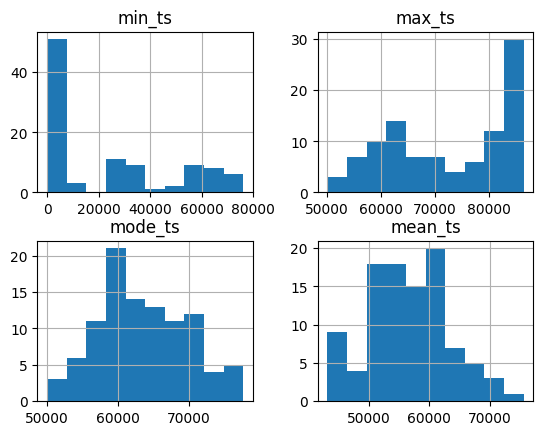

In [28]:
df_user_logoff_stats_sec.loc[df_user_log_result['anomaly_score'] < 0].hist()

In [11]:
# Lists to hold data from each file
connect_data = []
disconnect_data = []

# Iterate over each CSV file in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Full path to the CSV file
        csv_path = os.path.join(csv_directory, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_path, names=['User', 'Timestamp', 'PC', 'ActivityType', 'Action'])

        # Convert Timestamp to datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M:%S')

        # Filter DataFrame by action and append to the respective list
        connect_data.append(df[df['Action'] == 'Connect'])
        disconnect_data.append(df[df['Action'] == 'Disconnect'])

# Concatenate all connect and disconnect data into two separate DataFrames
connect_df = pd.concat(connect_data)
disconnect_df = pd.concat(disconnect_data)

# Function to format datetime as H:M:S
format_time = lambda x: x.strftime('%H:%M:%S')

# Calculate means for connect and disconnect
connect_means = connect_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))
disconnect_means = disconnect_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))

# Calculate modes for connect and disconnect
# We use scipy's mode function which returns the first mode in case of multimodal data
connect_modes = connect_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))
disconnect_modes = disconnect_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))

# Convert Series to DataFrame for CSV output
connect_means_df = connect_means.reset_index().rename(columns={'Timestamp': 'Connect_mean_time'})
connect_modes_df = connect_modes.reset_index().rename(columns={'Timestamp': 'Connect_mode_time'})

disconnect_means_df = disconnect_means.reset_index().rename(columns={'Timestamp': 'Disconnect_mean_time'})
disconnect_modes_df = disconnect_modes.reset_index().rename(columns={'Timestamp': 'Disconnect_mode_time'})

# Create stats DataFrame for connection data
df_device_conn_stats = connect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time.apply(format_time)
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time.apply(format_time)
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time'}, inplace=True)

# These variables hold the respective statistics for later use in your code:
# connect_means_df, connect_modes_df, disconnect_means_df, disconnect_modes_df

In [12]:
connect_means_df.head()

,User,Connect_mean_time
0,DTAA/ABB0272,19:20:46
1,DTAA/ABS0726,00:06:48
2,DTAA/ACH0803,14:59:06
3,DTAA/AFF0760,03:13:46
4,DTAA/AFH0331,10:56:46


In [13]:
connect_modes_df.head()

,User,Connect_mode_time
0,DTAA/ABB0272,15:47:45
1,DTAA/ABS0726,01:01:07
2,DTAA/ACH0803,16:05:54
3,DTAA/AFF0760,00:57:03
4,DTAA/AFH0331,07:57:22


In [14]:
disconnect_means_df.head()

,User,Disconnect_mean_time
0,DTAA/ABB0272,22:43:29
1,DTAA/ABS0726,00:36:46
2,DTAA/ACH0803,06:03:02
3,DTAA/AFF0760,03:44:57
4,DTAA/AFH0331,09:26:35


In [15]:
disconnect_modes_df.head()

,User,Disconnect_mode_time
0,DTAA/ABB0272,14:35:34
1,DTAA/ABS0726,01:01:46
2,DTAA/ACH0803,16:43:48
3,DTAA/AFF0760,01:02:11
4,DTAA/AFH0331,17:47:54


In [16]:
# Create stats DataFrame for connection data
df_device_conn_stats = connect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time',
                                     'Connect_mean_time': 'Connect_mean_time',
                                     'Connect_mode_time': 'Connect_mode_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time',
                                        'Disconnect_mean_time': 'Disconnect_mean_time',
                                        'Disconnect_mode_time': 'Disconnect_mode_time'}, inplace=True)

In [17]:
# Conversion of connection times to timestamps in seconds
for col in ['Connect_min_time', 'Connect_max_time', 'Connect_mode_time', 'Connect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_conn_stats[col + '_ts'] = pd.to_datetime(df_device_conn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_conn_stats[col + '_sec'] = df_device_conn_stats[col + '_ts'].apply(dtt2timestamp)

# Conversion of disconnection times to timestamps in seconds
for col in ['Disconnect_min_time', 'Disconnect_max_time', 'Disconnect_mode_time', 'Disconnect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_disconn_stats[col + '_ts'] = pd.to_datetime(df_device_disconn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_disconn_stats[col + '_sec'] = df_device_disconn_stats[col + '_ts'].apply(dtt2timestamp)

# Merge the connection and disconnection dataframes
df_device_full = pd.merge(df_device_conn_stats, df_device_disconn_stats, on='User')

# Select columns that end with '_sec' for analysis
sec_columns = [col for col in df_device_full.columns if col.endswith('_sec')]
device_full_array = df_device_full[sec_columns].values

# Set up and train IsolationForest model
forest = IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
                         max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
                         verbose=0)
forest.fit(device_full_array)

# Save the trained model to a pickle file
# with open('../pkl/device_params.pkl', 'wb') as file:
#     pickle.dump(forest, file)

# Calculate anomaly scores
df_device_full['anomaly_score'] = forest.decision_function(device_full_array)

# Identifying outliers
df_device_full_outliers = df_device_full[df_device_full['anomaly_score'] < 0]
print(df_device_full_outliers)

             User Connect_min_time Connect_max_time Connect_mean_time  \
1    DTAA/ABS0726         04:32:16         02:44:26          00:06:48   
8    DTAA/AIB0797         10:50:32         17:12:41          02:42:55   
10   DTAA/AJB0016         18:39:20         12:29:47          20:44:55   
42   DTAA/CHS0324         23:51:28         04:33:36          01:19:00   
44   DTAA/CLK0383         00:33:15         20:47:02          23:46:04   
46   DTAA/CMF0339         03:00:27         05:03:03          16:20:42   
47   DTAA/COS0121         13:23:56         00:10:59          14:54:24   
51   DTAA/CTR0537         00:54:40         21:55:26          22:54:48   
61   DTAA/DFZ0063         23:22:27         21:57:51          13:09:24   
88   DTAA/GYT0279         22:32:30         19:47:53          07:11:06   
98   DTAA/HNS0858         21:45:26         23:33:49          02:41:34   
107  DTAA/JAH0544         03:29:41         23:07:03          20:09:49   
109  DTAA/JBL0450         00:36:02         00:13:17

In [18]:
df_all = pd.DataFrame()

# Read all CSV files and concatenate into a single DataFrame
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(csv_directory, filename)
        df_temp = pd.read_csv(file_path, header=None)  # Assuming the CSV has no header
        df_temp.columns = ['User', 'Timestamp', 'PC', 'Activity', 'Action']  # Assign column names
        df_all = pd.concat([df_all, df_temp])

# Ensure 'Timestamp' is a datetime object
df_all['Timestamp'] = pd.to_datetime(df_all['Timestamp'], format='%m/%d/%Y %H:%M:%S')

# Filter out 'Logon' and 'Logoff' activities into separate DataFrames
df_logon = df_all[df_all['Action'] == 'Logon']
df_logoff = df_all[df_all['Action'] == 'Logoff']

# Define a function to perform the aggregation and transformation
def aggregate_user_pc_log_activities(df_activity):
    # Aggregate data to count the total number of activities per user per PC
    df_user_pc = df_activity.groupby(['User', 'PC']).size().reset_index(name='pc_activities_per_user_total')

    # Calculate the unique count of PCs per user
    df_user_pc['unique_pc_count'] = df_user_pc.groupby('User')['PC'].transform('nunique')

    # Keep only the 'User' and 'unique_pc_count' columns and drop duplicates
    df_user_pc = df_user_pc[['User', 'unique_pc_count']].drop_duplicates()

    return df_user_pc

# Apply the function to both logon and logoff DataFrames
df_user_pc_logon = aggregate_user_pc_log_activities(df_logon)
df_user_pc_logoff = aggregate_user_pc_log_activities(df_logoff)

# Optionally, save these dataframes to CSV
# df_user_pc_logon.to_csv('user_pc_logon.csv', index=False)
# df_user_pc_logoff.to_csv('user_pc_logoff.csv', index=False)

In [19]:
df_user_pc_logon

,User,unique_pc_count
0,DTAA/AAA0371,16
16,DTAA/AAC0344,1
17,DTAA/AAC0599,1
18,DTAA/AAH0734,1
19,DTAA/AAK0658,1
...,...,...
22244,DTAA/ZGH0528,1
22245,DTAA/ZKE0662,1
22246,DTAA/ZKH0388,44
22290,DTAA/ZKN0548,1


In [20]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pickle
import numpy as np

In [21]:
# Let's assume df_user_pc_logon and df_user_pc_logoff are obtained from the previous code
# We will use df_user_pc_logon for this example

# Prepare the data for the Isolation Forest
# Reshape the 'unique_pc_count' column to a 2D array
pc_counts = np.array(df_user_pc_logon['unique_pc_count']).reshape(-1, 1)

# Initialize the Isolation Forest model
forest = IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
                         max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
                         verbose=0)

# Fit the model
forest.fit(pc_counts)

# Serialize the model using pickle
with open('user_pc_ct_isolation_forest.pkl', 'wb') as file:
    pickle.dump(forest, file)

# Get the anomaly scores (the lower, the more abnormal)
anomaly_scores = forest.decision_function(pc_counts)

# Create a DataFrame to hold the results
results = pd.DataFrame()
results['user'] = df_user_pc_logon['User']
results['unique_pc_count'] = df_user_pc_logon['unique_pc_count']
results['anomaly_score'] = anomaly_scores

# Identify potential outliers
# Outliers are defined as observations with an anomaly score less than 0
df_unique_pc_outliers = results.loc[results['anomaly_score'] < 0]

# Display the results
print(results.head(10))  # Show the first 10 results
print(df_unique_pc_outliers)          # Show the outliers

             user  unique_pc_count  anomaly_score
0    DTAA/AAA0371               16       0.029559
16   DTAA/AAC0344                1       0.172174
17   DTAA/AAC0599                1       0.172174
18   DTAA/AAH0734                1       0.172174
19   DTAA/AAK0658                1       0.172174
20   DTAA/AAK0924                1       0.172174
21   DTAA/AAR0508                1       0.172174
22   DTAA/AAS0709               19       0.052007
41   DTAA/ABB0272               72      -0.028684
113  DTAA/ABD0833                1       0.172174
               user  unique_pc_count  anomaly_score
41     DTAA/ABB0272               72      -0.028684
117    DTAA/ABS0726               11      -0.015941
186    DTAA/AFG0122               74      -0.065364
320    DTAA/AGW0182               65      -0.007078
557    DTAA/AJN0804               71      -0.024168
...             ...              ...            ...
21719  DTAA/VMM0309               66      -0.006575
21792  DTAA/WCN0570               

In [22]:

df_user_log_result.head()

df_threat_users_log = df_user_log_result.loc[df_user_log_result['anomaly_score'] <= -0.04]
print(df_threat_users_log)

             User  anomaly_score
14   DTAA/ACD0647      -0.065916
45   DTAA/AJC0399      -0.099358
49   DTAA/AJS0917      -0.063754
90   DTAA/ARS0993      -0.047338
98   DTAA/ATJ0284      -0.064750
127  DTAA/BFO0974      -0.111052
131  DTAA/BGV0046      -0.059890
210  DTAA/CJG0638      -0.059951
217  DTAA/CLN0999      -0.055368
231  DTAA/CRC0996      -0.053863
232  DTAA/CRF0074      -0.059279
237  DTAA/CSC0297      -0.042890
239  DTAA/CSR0189      -0.055642
240  DTAA/CTF0687      -0.061053
249  DTAA/DAO0613      -0.047126
271  DTAA/DGM0240      -0.070234
294  DTAA/DSM0990      -0.041124
304  DTAA/EBP0037      -0.089122
326  DTAA/ELD1000      -0.045342
364  DTAA/GKC0919      -0.043654
368  DTAA/GML0105      -0.129564
374  DTAA/GRS0372      -0.104959
406  DTAA/HKM0260      -0.073742
432  DTAA/IGC0415      -0.044130
445  DTAA/IRH0176      -0.128278
459  DTAA/JCC0998      -0.049501
471  DTAA/JHA0404      -0.040876
520  DTAA/KEE0997      -0.051004
570  DTAA/LCL0792      -0.058595
595  DTAA/

In [23]:
df_log_on_off_stats[df_log_on_off_stats.User.isin(df_threat_users_log.User)]

,User,on_min_ts,on_max_ts,on_mode_ts,on_mean_ts,off_min_ts,off_max_ts,off_mode_ts,off_mean_ts
14,DTAA/ACD0647,22804,23997,22969,21600,22804,23997,22969,21600
45,DTAA/AJC0399,19443,85615,32018,39600,19443,85615,32018,39600
49,DTAA/AJS0917,22801,23999,23076,21600,22801,23999,23076,21600
90,DTAA/ARS0993,28,86345,28108,39600,28,86345,28108,39600
98,DTAA/ATJ0284,3336,80859,28044,25200,3336,80859,28044,25200
127,DTAA/BFO0974,7381,85544,24201,21600,7381,85544,24201,21600
131,DTAA/BGV0046,28231,57670,46237,32400,28231,57670,46237,32400
210,DTAA/CJG0638,32701,58577,32968,39600,32701,58577,32968,39600
217,DTAA/CLN0999,76,86399,32309,39600,76,86399,32309,39600
231,DTAA/CRC0996,48,86355,32091,39600,48,86355,32091,39600


/Users/aimee/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


             User Connect_min_time Connect_max_time Connect_mean_time  \
1    DTAA/ABS0726         04:32:16         02:44:26          00:06:48   
8    DTAA/AIB0797         10:50:32         17:12:41          02:42:55   
10   DTAA/AJB0016         18:39:20         12:29:47          20:44:55   
42   DTAA/CHS0324         23:51:28         04:33:36          01:19:00   
44   DTAA/CLK0383         00:33:15         20:47:02          23:46:04   
46   DTAA/CMF0339         03:00:27         05:03:03          16:20:42   
47   DTAA/COS0121         13:23:56         00:10:59          14:54:24   
51   DTAA/CTR0537         00:54:40         21:55:26          22:54:48   
61   DTAA/DFZ0063         23:22:27         21:57:51          13:09:24   
88   DTAA/GYT0279         22:32:30         19:47:53          07:11:06   
98   DTAA/HNS0858         21:45:26         23:33:49          02:41:34   
107  DTAA/JAH0544         03:29:41         23:07:03          20:09:49   
109  DTAA/JBL0450         00:36:02         00:13:17

,User,Connect_min_time,Connect_max_time,Connect_mean_time,Connect_mode_time,Connect_min_time_ts,Connect_min_time_sec,Connect_max_time_ts,Connect_max_time_sec,Connect_mode_time_ts,...,Disconnect_mode_time,Disconnect_min_time_ts,Disconnect_min_time_sec,Disconnect_max_time_ts,Disconnect_max_time_sec,Disconnect_mode_time_ts,Disconnect_mode_time_sec,Disconnect_mean_time_ts,Disconnect_mean_time_sec,anomaly_score
1,DTAA/ABS0726,04:32:16,02:44:26,00:06:48,01:01:07,04:32:16,16336,02:44:26,9866,01:01:07,...,01:01:46,04:49:50,17390,02:48:20,10100,01:01:46,3706,00:36:46,2206,-0.019480
8,DTAA/AIB0797,10:50:32,17:12:41,02:42:55,00:16:33,10:50:32,39032,17:12:41,61961,00:16:33,...,17:56:54,17:52:00,64320,19:13:36,69216,17:56:54,64614,20:41:12,74472,-0.006833
10,DTAA/AJB0016,18:39:20,12:29:47,20:44:55,17:26:10,18:39:20,67160,12:29:47,44987,17:26:10,...,16:59:49,18:13:20,65600,17:06:00,61560,16:59:49,61189,20:59:10,75550,-0.000805
42,DTAA/CHS0324,23:51:28,04:33:36,01:19:00,00:15:52,23:51:28,85888,04:33:36,16416,00:15:52,...,00:22:46,00:39:23,2363,04:34:52,16492,00:22:46,1366,22:57:16,82636,-0.059550
44,DTAA/CLK0383,00:33:15,20:47:02,23:46:04,00:33:15,00:33:15,1995,20:47:02,74822,00:33:15,...,00:39:21,00:39:21,2361,21:04:46,75886,00:39:21,2361,00:03:15,195,-0.037422
46,DTAA/CMF0339,03:00:27,05:03:03,16:20:42,02:52:04,03:00:27,10827,05:03:03,18183,02:52:04,...,00:33:42,03:02:07,10927,23:52:52,85972,00:33:42,2022,13:45:02,49502,-0.009178
47,DTAA/COS0121,13:23:56,00:10:59,14:54:24,00:01:35,13:23:56,48236,00:10:59,659,00:01:35,...,00:01:55,15:17:01,55021,01:05:46,3946,00:01:55,115,07:26:02,26762,-0.034312
51,DTAA/CTR0537,00:54:40,21:55:26,22:54:48,00:05:36,00:54:40,3280,21:55:26,78926,00:05:36,...,03:17:19,03:17:19,11839,22:57:02,82622,03:17:19,11839,01:07:01,4021,-0.034526
61,DTAA/DFZ0063,23:22:27,21:57:51,13:09:24,00:36:34,23:22:27,84147,21:57:51,79071,00:36:34,...,00:25:21,03:24:31,12271,22:23:23,80603,00:25:21,1521,00:34:17,2057,-0.041049
88,DTAA/GYT0279,22:32:30,19:47:53,07:11:06,04:44:43,22:32:30,81150,19:47:53,71273,04:44:43,...,00:37:10,00:37:10,2230,20:18:24,73104,00:37:10,2230,07:50:43,28243,-0.037601


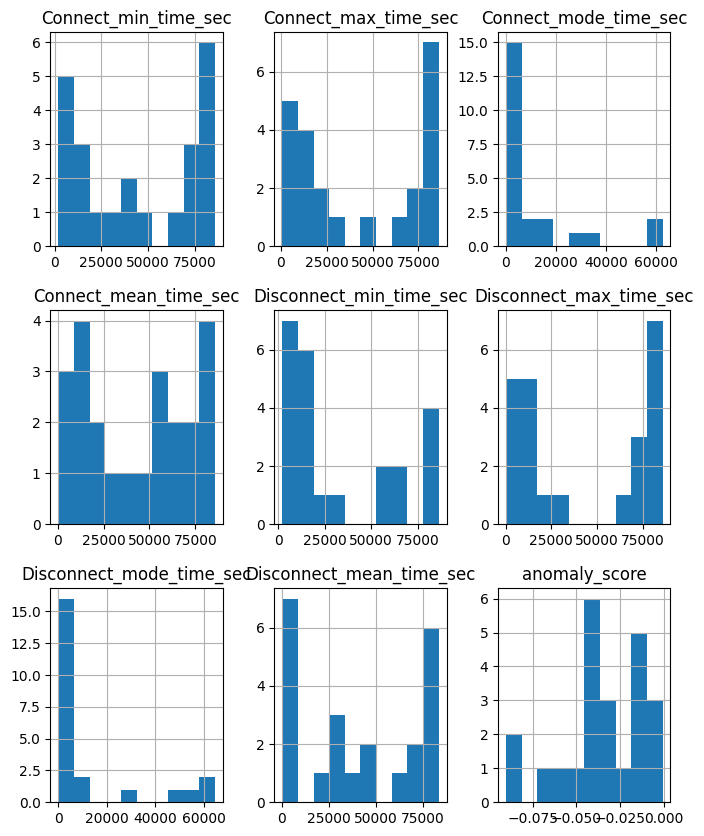

In [24]:
df_device_full_outliers.head()

fig = plt.figure(figsize=(8,10))
ax = fig.gca()

df_device_full_outliers.loc[df_device_full_outliers['anomaly_score'] < 0].hist(ax=ax)

df_threat_users_device_file = df_device_full_outliers.loc[df_device_full_outliers['anomaly_score'] <= 0]
print(df_threat_users_device_file)

df_device_full[df_device_full.User.isin(df_threat_users_device_file.User)]

               user  unique_pc_count  anomaly_score
41     DTAA/ABB0272               72      -0.028684
117    DTAA/ABS0726               11      -0.015941
186    DTAA/AFG0122               74      -0.065364
320    DTAA/AGW0182               65      -0.007078
557    DTAA/AJN0804               71      -0.024168
...             ...              ...            ...
21719  DTAA/VMM0309               66      -0.006575
21792  DTAA/WCN0570                8      -0.066239
21986  DTAA/XQW0354               69      -0.004734
22173  DTAA/YVF0045               66      -0.006575
22246  DTAA/ZKH0388               44      -0.010192

[98 rows x 3 columns]


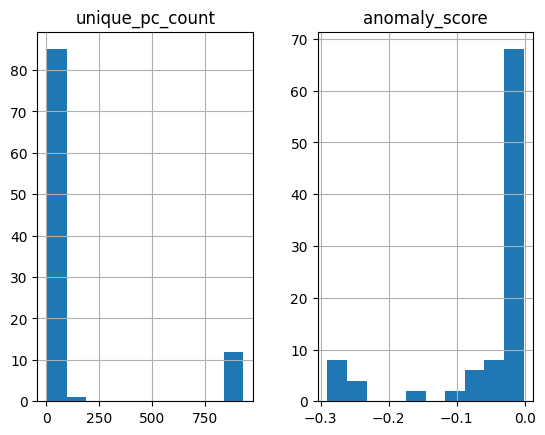

In [25]:


df_unique_pc_outliers.loc[df_unique_pc_outliers['anomaly_score'] < 0].hist()

df_threat_users_unique_pc = df_unique_pc_outliers.loc[df_unique_pc_outliers['anomaly_score'] <= 0]
print(df_threat_users_unique_pc)